In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import math
import pickle

In [2]:
# define the dataset location
filename = '../data/OnlineNewsPopularity.csv'

# Set Pandas to show all the columns
pd.set_option('display.max_columns', None)
# Read the data as a dataframe
data = pd.read_csv(filename)

## Data analysis

We realized that there is a misspelling in one columns naem, so we now correct the name of "self_reference_avg_sharess"
<br>
Also remove the spaces that there are at the beggining of each column name, to avoid future problems:

In [3]:
for column in data.columns:
    if column == ' self_reference_avg_sharess':
        data.rename(columns = {column:'self_reference_avg_shares'}, inplace = True)
    elif column == 'url':
        continue
    else:
        data.rename(columns = {column:column[1:]}, inplace = True)

Drop the "url" column as it is as an ID an makes no sense to train the model with it, it is not informative.

In [4]:
data = data.drop('url', axis = 1)

Now we will analyze the relation between variables, as it is important to take this into account when training the model

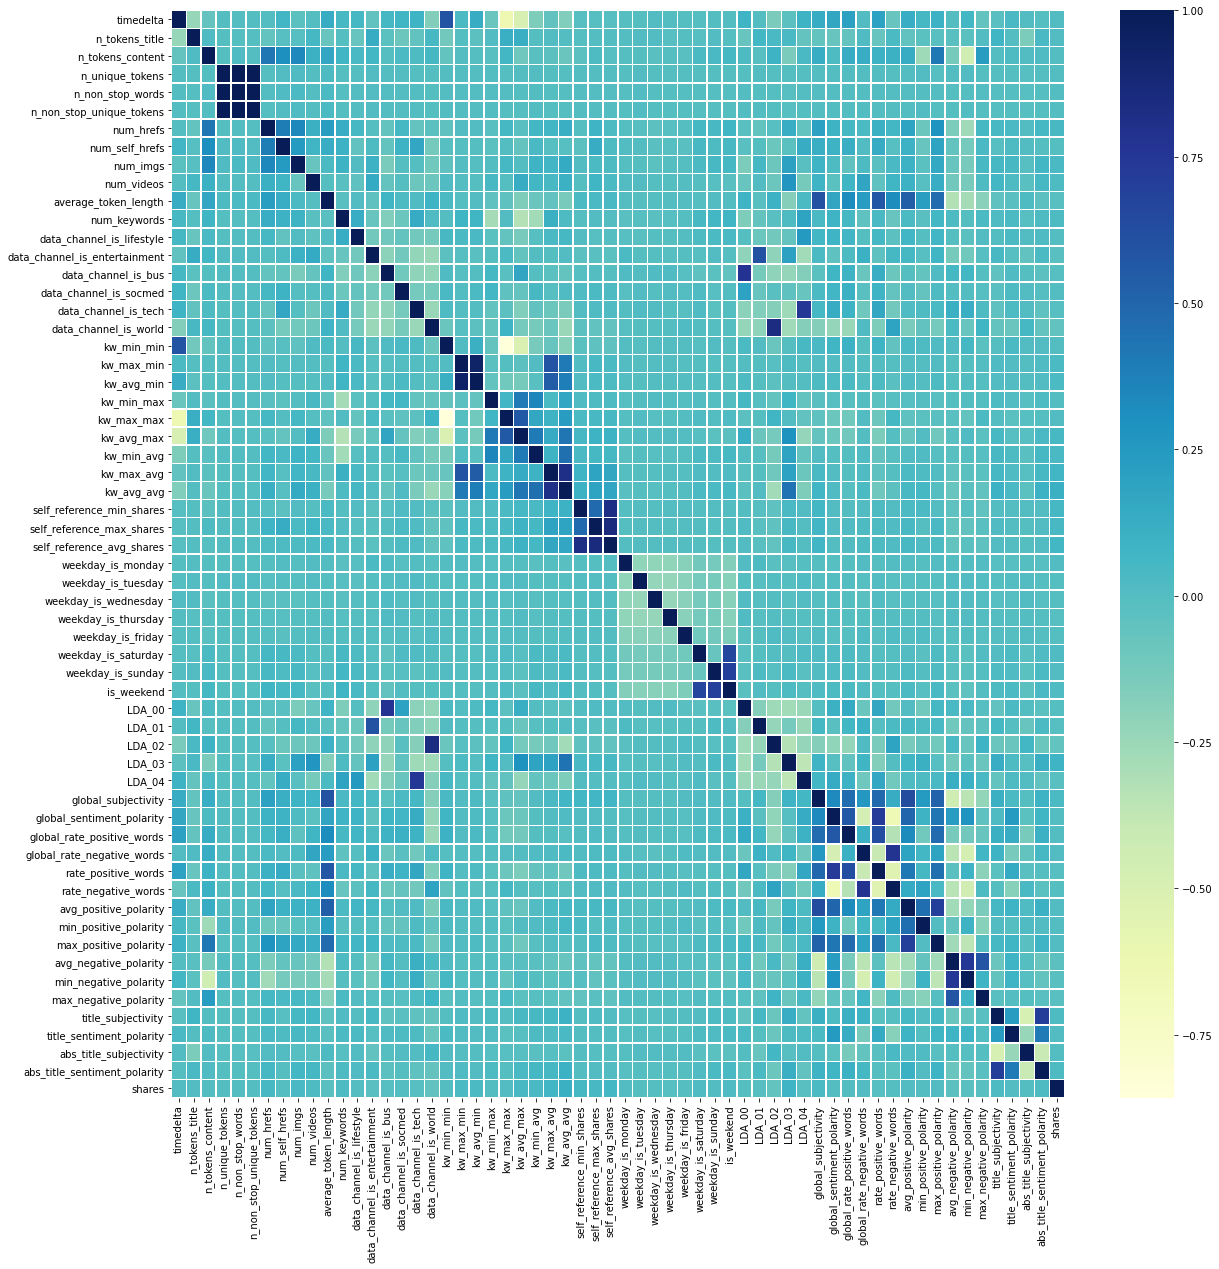

In [5]:
corr = data[data.columns].corr()

fig, ax = plt.subplots(figsize=(20,20),  nrows =1, ncols = 1)
sns.heatmap(corr,annot=False,linewidths=.5,cmap="YlGnBu")
plt.show()


We can see that it doesn't see like the variables we really correlated in general, so we will not drop any of them for the training.

In [6]:
print(corr['shares'].sort_values(ascending = False))

shares                           1.000000
kw_avg_avg                       0.110413
LDA_03                           0.083771
kw_max_avg                       0.064306
self_reference_avg_shares        0.057789
self_reference_min_shares        0.055958
self_reference_max_shares        0.047115
num_hrefs                        0.045404
kw_avg_max                       0.044686
kw_min_avg                       0.039551
num_imgs                         0.039388
global_subjectivity              0.031604
kw_avg_min                       0.030406
kw_max_min                       0.030114
abs_title_sentiment_polarity     0.027135
num_videos                       0.023936
title_subjectivity               0.021967
num_keywords                     0.021818
is_weekend                       0.016958
weekday_is_saturday              0.015082
title_sentiment_polarity         0.012772
avg_positive_polarity            0.012142
max_positive_polarity            0.010068
weekday_is_monday                0

When we look to the correlation with the number of shares of an article, we see that the correlations are really low. This can make that the models don't predict really well the popularity of an article given this data.

## Prepare data for training

Prepare the data for binary classification: 
<br> We will classify between 1=popular and 0=unpopular

In [9]:
threshold = 1400 #higher than this is 1:popular
for i in range(data.shape[0]):
    val = data.loc[i,'shares']
    if val >= threshold:
        data.loc[i,'popular'] = 1
    else:
        data.loc[i,'popular'] = 0

In [10]:
data.head(2)

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_shares,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popular
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.35000,-0.600,-0.2,0.5,-0.1875,0.0,0.1875,593,0.0
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.11875,-0.125,-0.1,0.0,0.0000,0.5,0.0000,711,0.0


Check that data is balanced with the threshold used:

In [11]:
dataPerClass = data['popular'].value_counts()
print(f"Amount of data for 'Popular': {dataPerClass[1]} and for 'NoPopular' {dataPerClass[0]}")

Amount of data for 'Popular': 21154 and for 'NoPopular' 18490


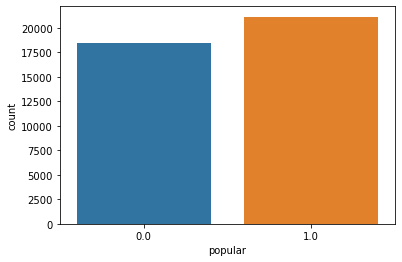

In [12]:
ax = sns.countplot(x='popular', data=data) 

We see that yes, data is balanced so we can train with it

## Understading effect of popular variable

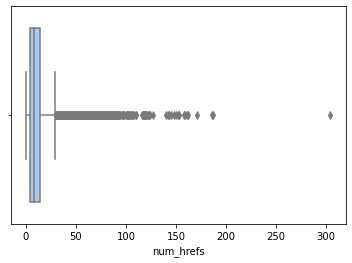

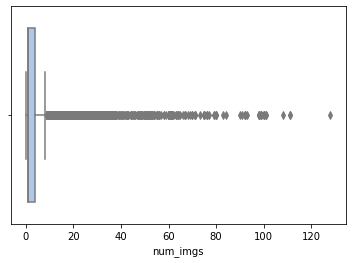

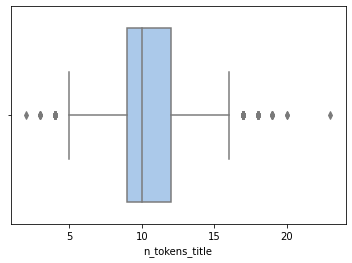

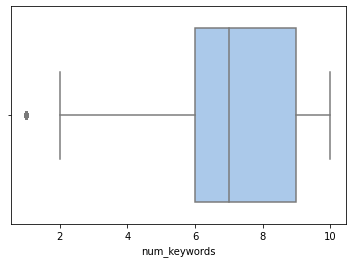

In [13]:
sns.boxplot(x='num_hrefs', hue='popular', data=data, palette="pastel")
plt.show()
sns.boxplot(x='num_imgs', hue='popular', data=data, palette="pastel") 
plt.show()
sns.boxplot(x='n_tokens_title', hue='popular', data=data, palette="pastel") 
plt.show()
sns.boxplot(x='num_keywords', hue='popular', data=data, palette="pastel") 
plt.show()

We can see that the number of references and number of images has a lot of outliers, it means that the quantity of these items varies a lot, the number of keywords and the number of words in the title, is a characteristic a bit more centered, for example in the words in title we can observe that is between 5 and 17.

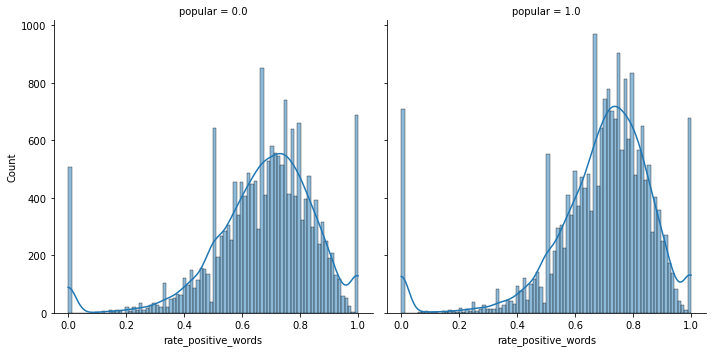

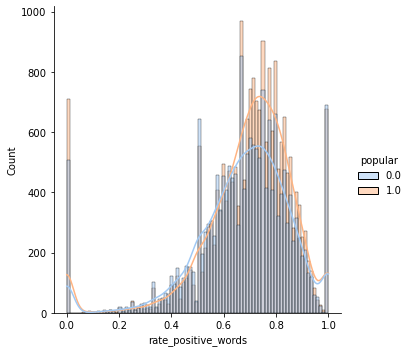

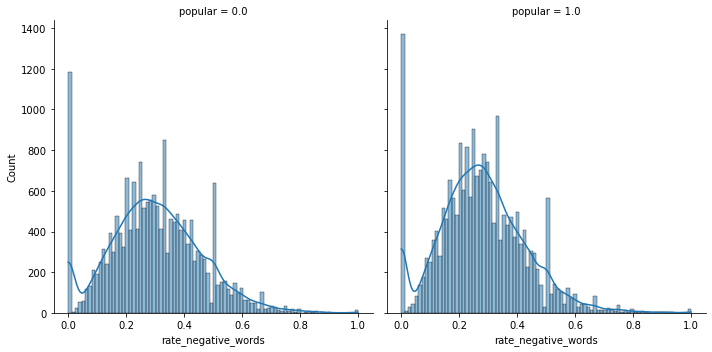

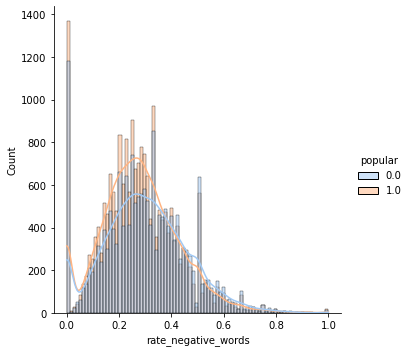

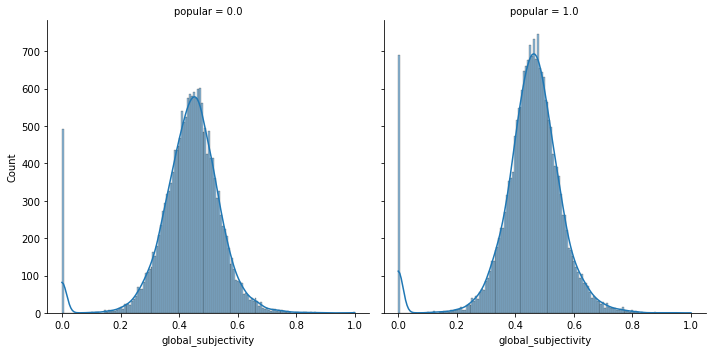

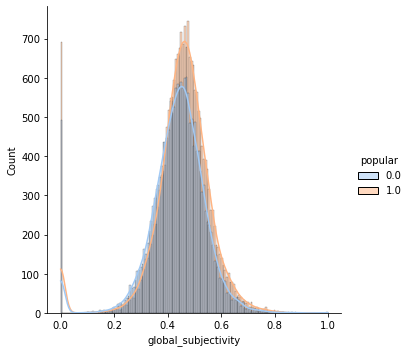

In [14]:
popular = data[data.popular == 1]
nonpopular = data[data.popular == 0]
for var in ['rate_positive_words', 'rate_negative_words', 'global_subjectivity']:
    x = sns.displot(x=var, data=data, palette='pastel', kde=True, col='popular')
    y = sns.displot(x=var, data=data, palette='pastel', kde=True, hue='popular')

In these distribution plots, we can see that more or less, the popular and the not popular news, have the same index of rate positive words, rate negative words and global subjectivity. But here the importance fact is the number of news, in the three distributions the popular news win. For the negative and positive words we can say that the popularity not depends on that because if the popular news have a lot of negative and positive words, the autor can write whatever he or she wants. But in the global subjectivity we can see that it is around 0.5, so we can say that as less subjective the autor is, the new has more probability to be popular. 

# Split data

In [15]:
y = data['popular']
variables = data.columns.drop(['shares','popular']) 
X = data[variables]

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 1)

# Export data

In [24]:
X_train.to_csv("../data/X_train.csv", index = False)
X_test.to_csv("../data/X_test.csv", index = False)

y_train.to_csv("../data/y_train.csv", index = False, header = 'popularity')
y_test.to_csv("../data/y_test.csv", index = False, header = 'popularity')